# Task 2

## Import Libraries

In [1]:
# import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, r_regression, f_regression
from sklearn.gaussian_process.kernels import Matern, RBF, CompoundKernel, Product, Sum, ExpSineSquared, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA

# boost algorithm
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

# torch
import torch
from torch import nn
from torch.nn import Module, Linear, Dropout
from torch.nn.functional import tanh, softmax, mse_loss, relu, sigmoid
from torch.optim import Adam, SGD

# bio library
import biosppy
from biosppy import storage
from biosppy.signals import ecg

DATA_DIR = "Data"

## Data Preprocessing

### Load Data

In [2]:
# Load Data
X_train_df = pd.read_csv(os.path.join(DATA_DIR, "X_train.csv"), header=0, index_col=0)
X_test_df = pd.read_csv(os.path.join(DATA_DIR, "X_test.csv"), header=0, index_col=0)
y_train_df = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv"), header=0, index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.ravel()

In [3]:
# 获取有效长度
X_train_len = []
for row in X_train:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_train_len.append(tail_id[0])
    else:
        X_train_len.append(X_train.shape[1])

X_test_len = []
for row in X_test:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_test_len.append(tail_id[0])
    else:
        X_test_len.append(X_test.shape[1])

X_train_len, X_test_len = np.array(X_train_len), np.array(X_test_len)

In [46]:
# get ecg features
ts_lst = []
filtered_lst = []
rpeaks_lst = []
templates_ts_lst = []
templates_lst = []
heart_rate_ts_lst = []
heart_rate_lst = []

def check_ecg_result(templates: np.ndarray):
    # 检查有没有一个template里有多个心跳的情况
    check_result = True
    error_num = 0
    for template in templates:
        peak_threshold = np.max(template) * 0.7
        peak_region = np.array(np.where(template > peak_threshold))
        if np.max(peak_region) - np.min(peak_region) > 0.5 * template.shape[0]:
            error_num += 1
    if error_num < templates.shape[0] * 0.33:
        check_result = True
    else:
        check_result = False
    return check_result

error_ids = []
error_templates = []
for i, (signal, sig_len) in enumerate(zip(X_train, X_train_len)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal[:sig_len], sampling_rate=300., show=False)
    # check template
    if check_ecg_result(templates) == False:
        error_ids.append(i)
        error_templates.append(templates)
        continue

    ts_lst.append(ts) # Signal time axis reference (seconds)
    filtered_lst.append(filtered) # Filtered ECG signal
    rpeaks_lst.append(rpeaks) # R-peak location indices
    templates_ts_lst.append(templates_ts) # Templates time axis reference
    templates_lst.append(templates) # Extracted heartbeat templates
    heart_rate_ts_lst.append(heart_rate_ts) # Heart rate time axis reference (seconds)
    heart_rate_lst.append(heart_rate) # Instantaneous heart rate (bpm)

y_train_new = np.delete(y_train, error_ids, axis=0)

In [65]:
def check_ecg_result(templates: np.ndarray):
    # 检查有没有一个template里有多个心跳的情况
    check_result = True
    for template in templates:
        peak_threshold = np.max(template) * 0.5
        peak_region = np.array(np.where(template > peak_threshold))
        if np.max(peak_region) - np.min(peak_region) > 0.33 * template.shape[0]:
            check_result = False
    return check_result
check_ecg_result(templates_lst[3])

True

In [47]:
y_train[error_ids]

array([1, 1, 1, 0, 2, 3, 1, 1, 2, 1, 1, 3, 0, 1, 2, 2, 0, 3, 1, 2, 1, 3,
       2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 3, 1, 2, 3, 1, 1, 1,
       2, 1, 2, 3, 2, 3, 1, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2, 3, 1, 0, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 3, 3, 0, 1, 3, 1, 3, 2, 2],
      dtype=int64)

In [35]:
for templates in error_templates:
    std_len = templates.shape[1]
    for template in templates:
        if template.shape[0] != std_len:
            print(False)

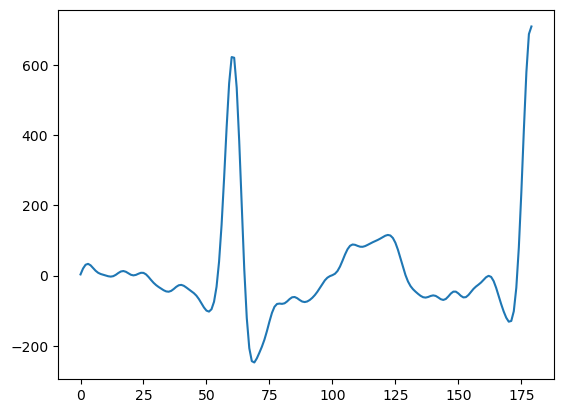

In [55]:
template = error_templates[1][15]
plt.plot(range(template.shape[0]), template)

In [59]:

check_ecg_result(templates_lst[3])

False

In [32]:
# get average template
max_height = None
for templates in templates_lst:
    for template in templates:
        if max_height is None or np.max(template) > max_height:
            max_height = np.max(template)

# scaler现在只是简单的缩放，不确定绝对高度有没有用
def scaler(template: np.array):
    result = template / max_height
    return result

def get_average_templates(templates):
    templates = scaler(templates)
    avg_templates = templates.sum(axis=0) / templates.shape[0]
    return avg_templates

avg_templates_lst = [get_average_templates(templates) for templates in templates_lst]

157

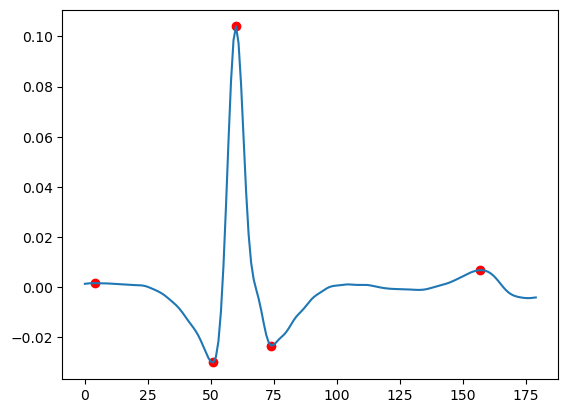

In [33]:
# 测试获取RQPST
templates = avg_templates_lst[10]

def get_PQRST_from_template(template: np.array):
    # get R
    R_id = np.where(template == np.max(template))[0][0]
    R = template[R_id]

    # get Q
    Q_id = np.where(template[:R_id] == np.min(template[:R_id]))[0][0]
    Q = template[Q_id]

    # get P
    P_id = np.where(template[:Q_id] == np.max(template[:Q_id]))[0][0]
    P = template[P_id]

    # get S
    S_id = np.where(template[R_id + 1:] == np.min(template[R_id + 1:]))[0][0] + R_id + 1
    S = template[S_id]

    # get T
    T_id = np.where(template[S_id + 1:] == np.max(template[S_id + 1:]))[0][0] + S_id + 1
    T = template[T_id]

    assert (P_id < Q_id and Q_id < R_id and R_id < S_id and S_id < T_id)

    # cal interval
    QRS = S_id - Q_id
    PR = R_id - P_id
    PQ = R_id - Q_id
    ST = T_id - S_id
    QT = T_id - Q_id
    return (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT)

(P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT) = get_PQRST_from_template(templates)

plt.plot(np.arange(0, templates.shape[0], 1), templates)
plt.scatter([P_id, Q_id, R_id, S_id, T_id], [P, Q, R, S, T], c="r")
T_id

In [30]:
# get P Q R S T
PQRST = []
for templates_i, templates in enumerate(templates_lst):
    template_PQRST = {
        "P": [], 
        "Q": [], 
        "R": [], 
        "S": [], 
        "T": [], 
        "P_id": [], 
        "Q_id": [], 
        "R_id": [], 
        "S_id": [], 
        "T_id": [], 
        "QRS": [], 
        "PR": [], 
        "PQ": [], 
        "ST": [], 
        "QT": [], 
    }
    for template_i, template in enumerate(templates):
        (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT) = get_PQRST_from_template(template)
        template_PQRST["P"].append(P)
        template_PQRST["Q"].append(Q)
        template_PQRST["R"].append(R)
        template_PQRST["S"].append(S)
        template_PQRST["T"].append(T)
        template_PQRST["P_id"].append(P_id)
        template_PQRST["Q_id"].append(Q_id)
        template_PQRST["R_id"].append(R_id)
        template_PQRST["S_id"].append(S_id)
        template_PQRST["T_id"].append(T_id)
        template_PQRST["QRS"].append(QRS)
        template_PQRST["PR"].append(PR)
        template_PQRST["PQ"].append(PQ)
        template_PQRST["ST"].append(ST)
        template_PQRST["QT"].append(QT)
    PQRST.append(template_PQRST)

ValueError: zero-size array to reduction operation maximum which has no identity

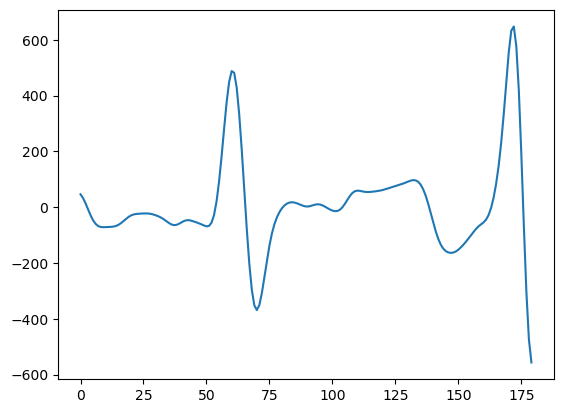

In [39]:
template = templates_lst[3][1]
plt.plot(range(template.shape[0]), template)